## Initial Stenosis model comparision experiments
### Notes:
**For all models apart from YOLO I used the StenUNet (https://arxiv.org/pdf/2310.14961) preprocessing method, the StenUNet augmentations, and to compare the impact of StenUNet's post processing algorithm, I ran each model with and without post-processing.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv("sten_exp_scores.csv", index_col='Model')
data

,Preprocessing,Augmentations,Postprocessing,Jaccard,F1,Recall,Precision,Acc,F2,HD,MFPS
Model,,,,,,,,,,,
ResUNet++,StenUNet,StenUNet,NaN,0.2516,0.3572,0.4339,0.3720,0.9851,0.3938,3.8237,168.528
ResUNet++ (PostProc),StenUNet,StenUNet,StenUNet,0.2519,0.3674,0.4334,0.3800,0.9851,0.3936,3.8279,NaN
DeepLabV3ResNet101,StenUNet,StenUNet,NaN,0.4335,0.5758,0.6052,0.6404,0.9920,0.5824,3.5716,96.739
DeepLabV3ResNet101 (PostProc),StenUNet,StenUNet,StenUNet,0.4337,0.5759,0.6049,0.6458,0.9921,0.5822,3.5748,NaN
Attention UNet,StenUNet,StenUNet,NaN,0.4213,0.5617,0.6338,0.5877,0.9912,0.5903,3.4762,233.800
Attention UNet (PostProc),StenUNet,StenUNet,StenUNet,0.4218,0.5616,0.6329,0.5917,0.9913,0.5898,3.4793,NaN
YOLOv8x-seg,StenUNet,YOLO,NaN,0.3234,0.4244,0.4315,0.7354,0.9914,0.4205,4.0100,44.643
YOLOv8x-seg (PostProc),StenUNet,YOLO,StenUNet,0.3163,0.4183,0.4124,0.7452,0.9915,0.4075,3.9999,NaN
TransUNet,StenUNet,StenUNet,NaN,0.0433,0.0741,0.1014,0.5846,0.9839,0.0827,4.5840,140.153


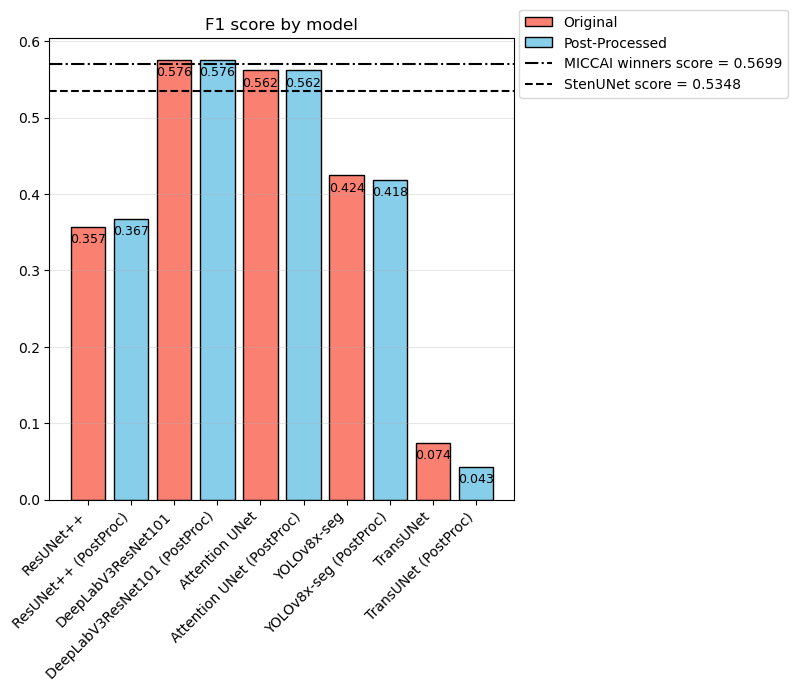

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(6,6)) # Add figure size for clarity

colors = ['skyblue' if '(PostProc)' in str(label) else 'salmon' for label in data.index]
ax.bar(data.index, data['F1'], color=colors, edgecolor='black')

ax.axhline(y=0.5699, color='black', linestyle='dashdot', label='MICCAI winners score = 0.5699')
ax.axhline(y=0.5348, color='black', linestyle='dashed', label='StenUNet score = 0.5348')

ax.set(title='F1 score by model')
ax.grid(True, axis='y', alpha=0.3)

for i, v in enumerate(data['F1']):
    ax.text(i, v-0.025, f"{v:.3f}", ha='center', va='bottom', fontsize=9)

color_legend = [
    Patch(facecolor='salmon', edgecolor='black', label='Original'),
    Patch(facecolor='skyblue', edgecolor='black', label='Post-Processed'),
]

# Combine all legend handles
handles, labels = ax.get_legend_handles_labels()
handles = color_legend + handles  # Color key first
ax.legend(handles=handles, loc=(1.01,0.87))
plt.xticks(rotation=45, ha='right')
plt.show()

## Comments
- StenUnet's post processing algorithm only improved results for ResUNet++. It actually reduced the scores for YOLOv8 and TransUNet. This may or may not be due to the threshold chosen
- TransUNet underperformed. I think this is due to the model oversegmenting, and getting distracted by the entire vessel overall rather than just the area of stenosis.
- DeepLabV3ResNet101 (in built torch model) actually managed to **just** beat the MICCAI winners by 0.007
- AttentionUNet beat the StenUNet score but not the MICCAI winners.

## Next steps
- Quick experiment with post processing threshold
- Experiment with different optimisers? They all used Adam, apart from YOLO which I left as auto
- Add my own block to one of the models to try and improve - maybe add a residual block/s to Attention UNet